In [17]:
# Importando Bibliotecas
import os
import torch
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

In [18]:
DATA_DIR = './'
CATEGORIES = ['Avião', 'Automóvel','Passáro','Gato','Cervo','Cachorro', 'Sapo', 'Cavalo', 'Navio', 'Caminhão']

In [19]:
# Dados
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [20]:
(len(cifar10_train), len(cifar10_test))

(50000, 10000)

In [21]:
import torchvision.transforms as tt
prep_transform = tt.Compose([tt.ToTensor(), tt.Normalize(
    (0.4914, 0.4822, 0.4465),
    (0.2470, 0.2435, 0.2616)
)])
tensor_train = CIFAR10(DATA_DIR, train=True, download=False, transform=prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False, transform=prep_transform)

In [22]:
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [23]:
imgs.view(3, -1).mean(dim=1) # Média das Cores

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [24]:
imgs.view(3, -1).std(dim=1) # Desvio Padrão das Cores

tensor([1.0001, 0.9999, 1.0000])

In [25]:
from torch.utils.data import DataLoader
batch_size = 64

train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

In [26]:
# Testando o MLP para classificar imagem

from torch import nn

class MLPClassifier(nn.Module) :
    def __init__(self) :
        super().__init__()

        self.flatten = nn.Flatten()

        self.layers = nn.Sequential(
            nn.Linear(32 * 32 * 3, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x) :
        v = self.flatten(x)
        return self.layers(v)

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Rodando na {device}')

Rodando na cuda


In [28]:
model = MLPClassifier().to(device)

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
lossfunc = nn.CrossEntropyLoss()

In [30]:
def train(model, dataloader, lossfunc, optimizer) :
    model.train(True)
    cumloss = 0.0
    for imgs, labels in dataloader :
        imgs, labels = imgs.to(device), labels.to(device)
        pred = model(imgs)
        loss = lossfunc(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumloss += loss.item()
    return cumloss / len(dataloader)

def validate(model, dataloader, loss_func) :
    model.eval()
    cumloss = 0.0
    with torch.no_grad() :
        for imgs, labels in dataloader :
            imgs, labels = imgs.to(device), labels.to(device)
            pred = model(imgs)
            loss = loss_func(pred, labels)
            cumloss += loss.item()
        return cumloss / len(dataloader)

In [31]:
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteração", fontsize="16")
    ax.set_ylabel("Perda", fontsize="16")
    ax.set_title("Perdas vs Iterações", fontsize="16")

In [32]:
epochs = 100
train_losses = []
test_losses = []
for t in range(epochs) :
    train_loss = train(model, train_loader, lossfunc, optimizer)
    train_losses.append(train_loss)
    test_loss = validate(model, test_loader, lossfunc)
    test_losses.append(test_loss)
    if(t % 10 == 0) :
        print(f"[Época][{t}] - Erro de Treinamento : {train_loss} - Erro de Validação : {test_loss}")



[Época][0] - Erro de Treinamento : 2.2965253402509958 - Erro de Validação : 2.2848412853896996
[Época][10] - Erro de Treinamento : 1.8530403195744585 - Erro de Validação : 1.834770529133499
[Época][20] - Erro de Treinamento : 1.6303158961903408 - Erro de Validação : 1.6216576554972655
[Época][30] - Erro de Treinamento : 1.5108938895527968 - Erro de Validação : 1.5255726651780923
[Época][40] - Erro de Treinamento : 1.4066314892390805 - Erro de Validação : 1.4543319204051024
[Época][50] - Erro de Treinamento : 1.3140732794618972 - Erro de Validação : 1.4047074978518639
[Época][60] - Erro de Treinamento : 1.2271834748327886 - Erro de Validação : 1.3725651768362446
[Época][70] - Erro de Treinamento : 1.1412111308111255 - Erro de Validação : 1.3515764630524216
[Época][80] - Erro de Treinamento : 1.0585964306845994 - Erro de Validação : 1.363534950906304
[Época][90] - Erro de Treinamento : 0.9749698172444883 - Erro de Validação : 1.3585142747611756


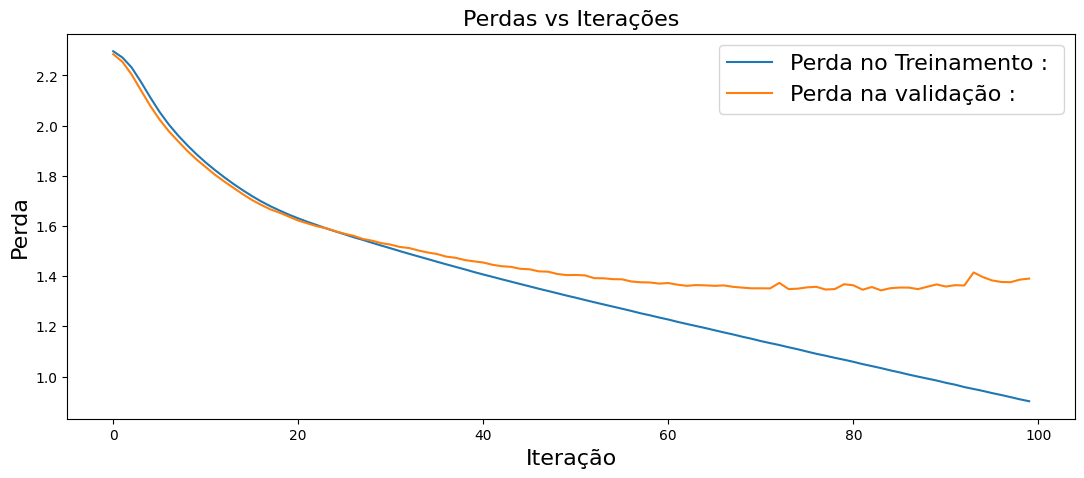

In [33]:
losses = {"Perda no Treinamento : " :  train_losses, "Perda na validação : " : test_losses}
plot_losses(losses)

In [88]:
import sysconfig
from PIL import Image
img = Image.open('./Fusca.jpg')

In [89]:
prep_transforms = tt.Compose([
    tt.Resize((32,32)),
    tt.ToTensor(),
    tt.Normalize(
    (0.4914, 0.4822, 0.4465),
    (0.2470, 0.2435, 0.2616))

])

img_tensor = prep_transforms(img)

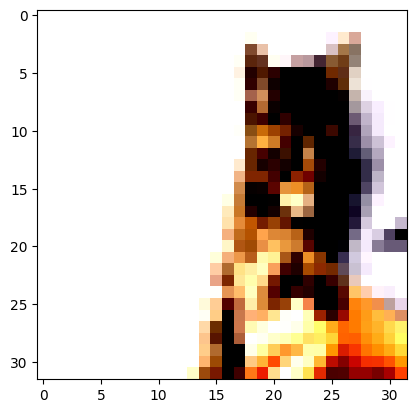

In [90]:
plt.imshow(img_tensor.permute(1,2, 0))

In [91]:
batch = img_tensor.unsqueeze(0).to(device)

In [92]:
import operator
output = model(batch)
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}



for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  prob_dict[classname] = [prob]

result = max(prob_dict.items(), key=operator.itemgetter(1))
result

('Gato', [49.63661575317383])